In [1]:
## imports
import pickle

import numpy as np
import openml
from sklearn.metrics import accuracy_score
from sklearn.model_selection import (
    StratifiedKFold,  # use X = np.zeros(n_samples) in .split
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from btv import *

from matplotlib import pyplot as plt
# from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

# if you have indeces and want knns from large set, can make an idx array and NearestVectorCaller._call_vec_set; can just train/test split np.arange(len(ds)) to get back indeces for large sets

In [2]:
## Data setup
electric_ds = openml.datasets.get_dataset(dataset_id=44156)
electric_df, *_ = electric_ds.get_data()
print(electric_ds)
X = electric_df.loc[:, [x != "class" for x in electric_df.columns]]
y = electric_df.loc[:, "class"]
le = LabelEncoder()
y = le.fit_transform(y)
print(sum(y) / len(y))  # fraction of "UP" periods

OpenML Dataset
Name..........: electricity
Version.......: 13
Format........: arff
Upload Date...: 2022-07-10 10:34:54
Licence.......: Public
Download URL..: https://api.openml.org/data/v1/download/22103281/electricity.arff
OpenML URL....: https://www.openml.org/d/44156
# of features.: 9
# of instances: 38474
0.5


In [3]:
## Model setup
from sklearn.ensemble import GradientBoostingClassifier

## could do a little metaparameter search
clf = GradientBoostingClassifier(
    n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0
)

In [21]:
## standard train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7941520467836257

In [20]:
y_predicted = clf.predict_proba(X_test)
prediction_entropy(y_test,y_predicted)

array([0.27043535])

In [6]:
## with straigh vectorization of whole images, the knn accuracy goes down as more data is added. Therefore that vecotrization is shit. Maybe we try tabular data?

kfold_idx_gen = StratifiedKFold(n_splits=5).split(X, y)
train_idx = np.array([], int)
running_train, entropies, train_idx = [], [], []
for k, (_, test_idx) in enumerate(kfold_idx_gen):
    running_train.append(test_idx)
running_test = running_train.pop()
for k, old_test_idx in enumerate(running_train):
    train_idx = np.append(train_idx, old_test_idx).astype(int)
    clf.fit(X.iloc[train_idx], y[train_idx])
    y_predicted = clf.predict_proba(X.iloc[running_test])
    y_true = y[running_test]
    H = prediction_entropy(y_true, y_predicted)
    entropies.append(H)
    print(
        f"Fold : {k+1}, " f"Test set entropy : {np.mean(H)}",
        f"Train samples : {len(train_idx)}",
        f"Accuracy : {accuracy_score(y_true,clf.predict(X.iloc[test_idx]))}",
    )

Fold : 1, Test set entropy : 3.362620223550819 Train samples : 7695 Accuracy : 0.4633480634260463
Fold : 2, Test set entropy : 1.9594489212373278 Train samples : 15390 Accuracy : 0.454639979204575
Fold : 3, Test set entropy : 2.0679750454899923 Train samples : 23085 Accuracy : 0.43878346763711984
Fold : 4, Test set entropy : 1.2438263582011957 Train samples : 30780 Accuracy : 0.5055887704704964


In [81]:
## add_best_fold_first_test
n_splits=10
verbose = True

kfold_idx_gen = StratifiedKFold(n_splits=n_splits).split(X, y)
train_idx = np.array([], int)
running_train, entropies, train_idx, scores, samples = [], [], [], [], []
for k, (_, test_idx) in enumerate(kfold_idx_gen):
    running_train.append(test_idx)
running_train = [list(x) for x in running_train]
running_test = running_train.pop()
iters = len(running_train)
      
for k in range(iters):
    best_fold_idxs = order_folds_by_entropy(X, y, clf, running_train)[0]
    train_idx = np.append(train_idx, best_fold_idxs).astype(int)
    running_train.remove(list(best_fold_idxs))

    clf.fit(X.iloc[train_idx], y[train_idx])
    y_predicted = clf.predict_proba(X.iloc[running_test])
    y_true = y[running_test]
    H = prediction_entropy(y_true, y_predicted)
    score = clf.score(X.iloc[test_idx], y_true)
    entropies.append(H)
    scores.append(score)
    samples.append(len(train_idx))
    if verbose:
        print(
            f"Fold : {k+1}, " f"Test set entropy : {np.mean(H)}",
            f"Train samples : {len(train_idx)}",
            f"Score : {score}",
        )

0: 9
Fold : 1, Test set entropy : 3.5976085261242527 Train samples : 3848 Score : 0.4795944892123733
Fold : 2, Test set entropy : 2.90512087340785 Train samples : 7695 Score : 0.4471016376397193
Fold : 3, Test set entropy : 1.4499610085781127 Train samples : 11542 Score : 0.4650376917078243
Fold : 4, Test set entropy : 1.2742396672732 Train samples : 15389 Score : 0.45256043670392515
Fold : 5, Test set entropy : 1.4172082141928775 Train samples : 19236 Score : 0.4473615804523005
Fold : 6, Test set entropy : 1.384195476995061 Train samples : 23084 Score : 0.461398492331687
Fold : 7, Test set entropy : 1.5393813361060567 Train samples : 26932 Score : 0.4460618663893943
Fold : 8, Test set entropy : 1.1005978684689368 Train samples : 30779 Score : 0.5687548739277359
Fold : 9, Test set entropy : 1.4354042110735639 Train samples : 34627 Score : 0.49285157265401613


In [24]:
samples, hs0, ss0 = add_stratified_folds_test(X,y,clf, 10, verbose=False)

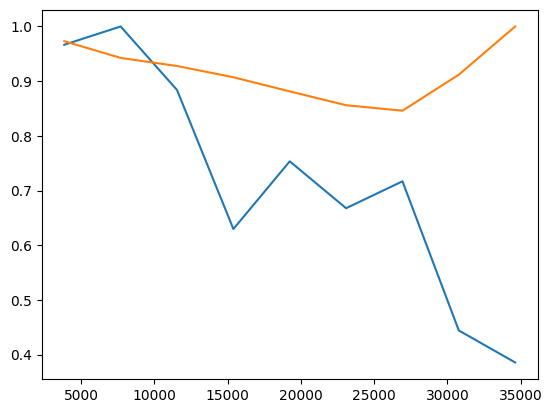

In [25]:
plt.plot(samples,hs0/max(hs0))
plt.plot(samples,ss0/max(ss0))

In [22]:
samples, hs1, ss1 = add_best_fold_first_test(X,y,clf, 10, verbose=False)

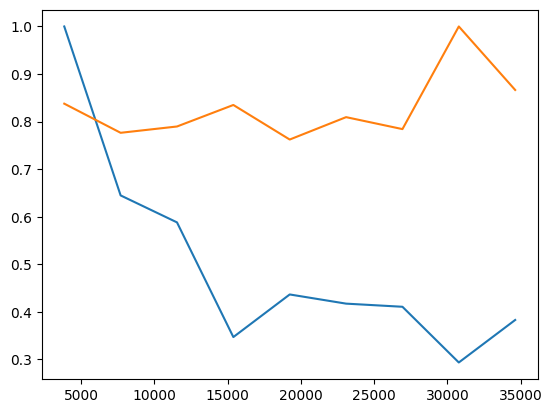

In [23]:
plt.plot(samples,hs1/max(hs1))
plt.plot(samples,ss1/max(ss1))

In [28]:
# cutting data finer gets to the relavent data faster
samples, hs2, ss2 = add_best_fold_first_test(X,y,clf, 100, verbose=False)

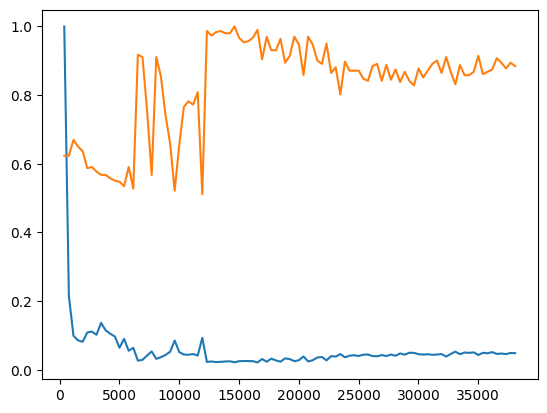

In [29]:
plt.plot(samples,hs2/max(hs2))
plt.plot(samples,ss2/max(ss2))